<a href="https://colab.research.google.com/github/AndreisMarco/02456_G128_bird_classification/blob/main/scripts/06_Audio_classification_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- check: https://towardsdatascience.com/cnns-for-audio-classification-6244954665ab

# 1. Set up environment

In [1]:
!pip install datasets evaluate --quiet

## 1.1 Import libraries

In [2]:
# setting up Drive and path for data loading and saving
import os
from google.colab import drive

# for data processing
import pandas as pd
from datasets import Dataset
from transformers import AutoFeatureExtractor

# for model training and evaluation
import torch
from torch import nn
from tqdm import tqdm
import numpy as np

# for visualisation
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 1.2 Load data

In [4]:
# mount Drive and set path
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Deep Learning - DTU 2024/'
os.chdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# load (one batch of) preprocessed data
batch_path = 'batch_1'
dataset = Dataset.load_from_disk(batch_path).remove_columns('__index_level_0__')

In [6]:
# inspect structure
dataset

Dataset({
    features: ['audio', 'label'],
    num_rows: 1244
})

In [7]:
dataset[0].keys()

dict_keys(['audio', 'label'])

In [8]:
num_classes = len(set(dataset["label"]))
print(f"Number of classes in the dataset: {num_classes}")

Number of classes in the dataset: 4


### 1.2.x Feature Extraction

In [9]:
model_dir = 'facebook/wav2vec2-base-960h'
feature_extractor = AutoFeatureExtractor.from_pretrained(model_dir)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [10]:
# extract features - from Marco's code
def preprocess_function(example):
    inputs = feature_extractor(example['audio'], sampling_rate=16000, padding=True)
    return inputs
dataset = dataset.map(preprocess_function, remove_columns="audio", batched=True, batch_size=32)
print("Preprocessed dataset with feature extractor.")

Preprocessed dataset with feature extractor.


### 1.2.x Split Dataset

In [11]:
# split dataset into train, val and test - from Marco's code
dataset = dataset.train_test_split(test_size=0.1, shuffle=True, stratify_by_column="label", seed=42)
print("Split dataset into training and testing.")

Split dataset into training and testing.


### 1.2.x Classes

In [12]:
# from Marco's code - not sure if needed

from sklearn.utils.class_weight import compute_class_weight

# Compute class weights and store in a dict
class_weights = compute_class_weight('balanced', classes=np.unique(dataset['train']['label']), y=dataset['train']['label'])
class_weights = {class_id: weight for class_id, weight in zip(np.unique(dataset['train']['label']), class_weights)}
print(f"Computed class weights: {class_weights}")
# Convert weights to Tensor
class_weight_tensor = torch.tensor(list(class_weights.values()), dtype=torch.float32).to(device)
print(f"Class weights tensor moved to device: {device}")

Computed class weights: {19: 1.5985714285714285, 40: 0.8797169811320755, 47: 1.8048387096774194, 49: 0.5939490445859873}
Class weights tensor moved to device: cuda


### 1.2.x Evaluation

In [13]:
import evaluate

# Use accuracy as performace metric
accuracy = evaluate.load("accuracy")

### 1.2.x Dataset to Loader

In [14]:
# from torch.nn.utils.rnn import pad_sequence

MAX_LENGTH = 160000  # Use the longest sequence length in your dataset

def collate_fn(batch):
    inputs = []
    for item in batch:
        input_values = item['input_values'].clone().detach()

        # running the line below didn't work properly, I had to manually pad
        # padded_inputs = pad_sequence(inputs, batch_first=True).unsqueeze(1)

        if len(input_values) < MAX_LENGTH: # pad
            padded = torch.cat((input_values, torch.zeros(MAX_LENGTH - len(input_values))))
        else: # truncate
            padded = input_values[:MAX_LENGTH]
        inputs.append(padded)
    labels = torch.tensor([item['label'] for item in batch])
    return torch.stack(inputs).unsqueeze(1), labels

In [15]:
# convert dataset col to tensors
dataset['train'].set_format(type='torch', columns=['input_values', 'label'])
dataset['test'].set_format(type='torch', columns=['input_values', 'label'])

### 1.2.x Intitiating CNN

In [16]:
import torch
import torch.nn as nn

class AudioCNN(nn.Module):
    def __init__(self, num_classes):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(2, 2)
        self.fc1 = nn.Linear(64 * 40000, 256)  # input size should be 160000, which is confirmed wile the model was trained
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # First convolution and pooling
        # debug step:
        # print("Shape after conv1:", x.shape)  # Print the shape after conv1

        x = self.pool(self.relu(self.conv2(x)))  # Second convolution and pooling
        # print("Shape after conv2:", x.shape)

        x = x.view(x.size(0), -1)  # Flatten the tensor
        #print("Shape after flattening:", x.shape)

        x = self.relu(self.fc1(x))  # First fully connected layer
        # print("Shape after fc1:", x.shape)
        # x = self.dropout(x)
        # print("Shape after dropout:", x.shape)

        x = self.fc2(x)  # Second fully connected layer (output)
        # print("Shape after fc2:", x.shape)
        return x

In [17]:
cnn = AudioCNN(num_classes).to(device)
print(cnn)

AudioCNN(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2560000, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
  (relu): ReLU()
)


In [18]:
loss_fct = nn.CrossEntropyLoss(weight=class_weight_tensor)
optimizer = torch.optim.Adam(cnn.parameters(), lr=3e-4, weight_decay=0.01)

### 1.2.x Training the Model

In [19]:
from torch.utils.data import DataLoader

num_epochs = 1
batch_size = 8

# load data
train_loader = torch.utils.data.DataLoader(dataset['train'], batch_size=batch_size, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(dataset['test'], batch_size=batch_size, collate_fn=collate_fn)

# init metric containers
train_iter, train_losses, train_accs = [], [], []
test_iter, test_losses, test_accs = [], [], []

# train and evaluate
for epoch in range(num_epochs):
  cnn.train()
  step = 0
  for inputs, labels in train_loader:
    step += 1

    inputs, labels = inputs.to(device), labels.to(device)
    # print(f"Shape of inputs before passing to model: {inputs.shape}")

    # reassign labels from 0-(n-1)
    labels = torch.clamp(labels, 0, num_classes - 1).long()
    # print(f"Unique values in labels: {torch.unique(labels)}")

    optimizer.zero_grad()
    outputs = cnn(inputs)

    loss = loss_fct(outputs, labels)
    loss.backward()
    optimizer.step()

    if step % 10 == 0:
      train_iter.append(step)
      train_losses.append(loss.item())
      train_acc = accuracy.compute(predictions=outputs.argmax(axis=1), references=labels)['accuracy']
      train_accs.append(train_acc)
      print(f"Epoch [{epoch+1}/{num_epochs}], Step [{step}/{len(train_loader)}], Train loss: {loss.item():.4f}, Train accuracy: {train_acc:.4f}")

      # calculate, append and display evaluation reports
      cnn.eval()
      test_loss, test_acc = 0, 0
      with torch.no_grad():
        for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          labels = torch.clamp(labels, 0, num_classes - 1).long()
          outputs = cnn(inputs)
          test_loss += loss_fct(outputs, labels).item()
          test_acc += accuracy.compute(predictions=outputs.argmax(axis=1), references=labels)['accuracy']

        # append to reports
        test_iter.append(step + epoch*len(train_loader))
        test_losses.append(test_loss / len(test_loader))
        test_accs.append(test_acc / len(test_loader))

        # display reports
        print(f"Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_acc / len(test_loader):.4f}")

print('')
print(f'Final training loss: {str(train_losses[-1])} accuracy: {str(train_accs[-1])}')
print(f'Final validation loss: {str(test_losses[-1])} accuracy: {str(test_accs[-1])}')

Epoch [1/1], Step [10/140], Train loss: 0.0000, Train accuracy: 1.0000
Test Loss: 0.0000, Test Accuracy: 1.0000
Epoch [1/1], Step [20/140], Train loss: 0.0000, Train accuracy: 1.0000
Test Loss: 0.0000, Test Accuracy: 1.0000
Epoch [1/1], Step [30/140], Train loss: 0.0000, Train accuracy: 1.0000
Test Loss: 0.0000, Test Accuracy: 1.0000
Epoch [1/1], Step [40/140], Train loss: 0.0000, Train accuracy: 1.0000
Test Loss: 0.0000, Test Accuracy: 1.0000
Epoch [1/1], Step [50/140], Train loss: 0.0000, Train accuracy: 1.0000
Test Loss: 0.0000, Test Accuracy: 1.0000
Epoch [1/1], Step [60/140], Train loss: 0.0000, Train accuracy: 1.0000
Test Loss: 0.0000, Test Accuracy: 1.0000
Epoch [1/1], Step [70/140], Train loss: 0.0000, Train accuracy: 1.0000
Test Loss: 0.0000, Test Accuracy: 1.0000
Epoch [1/1], Step [80/140], Train loss: 0.0000, Train accuracy: 1.0000
Test Loss: 0.0000, Test Accuracy: 1.0000
Epoch [1/1], Step [90/140], Train loss: 0.0000, Train accuracy: 1.0000
Test Loss: 0.0000, Test Accuracy:

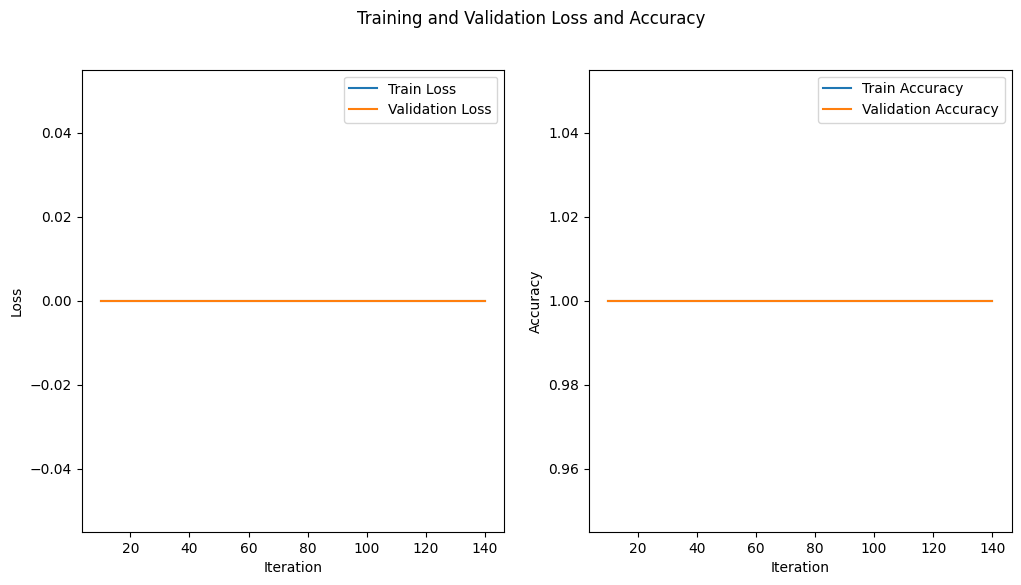

In [20]:
# plots of final loss and accuracy of training and validation data
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_iter, train_losses, label='Train Loss')
plt.plot(test_iter, test_losses, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_iter, train_accs, label='Train Accuracy')
plt.plot(test_iter, test_accs, label='Validation Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()

plt.suptitle('Training and Validation Loss and Accuracy')

plt.show()